In [2]:
import pandas as pd
import numpy as np

In [28]:
prices_data = pd.read_csv("futures-pnls.csv")

In [29]:
prices_data.index = pd.to_datetime(prices_data["Date"])

In [30]:
tickers = ['BPA', 'CAA', 'DAA', 'EUA', 'MXA', 'SFA', 'EP', 'NKD', 'VX']

needed_columns = tickers + ['Date']

prices_data = prices_data[needed_columns]

In [31]:
initial_price_columns = [col for col in prices_data.columns if col != 'Date']
window_size = 30*72
inv_vol_cols = []

for column_name in initial_price_columns:
    prices_data[f'Log_Ret_{column_name}'] = np.log(prices_data[column_name] / prices_data[column_name].shift(1)).fillna(0)
    prices_data[f'Volatility_{column_name}'] = prices_data[f'Log_Ret_{column_name}'].rolling(window=window_size).std() * np.sqrt(window_size)
    prices_data[f'Inverse_Volatility_{column_name}'] = 1/prices_data[f'Volatility_{column_name}']
    inv_vol_cols.append(f'Inverse_Volatility_{column_name}')

In [32]:
start_of_day_data = prices_data.resample('D').first()

In [33]:
start_of_day_data.dropna(subset=['Date'] + inv_vol_cols, inplace=True)

In [34]:
log_returns_volatility_targeting = []
log_returns_buy_hold_baseline = []
for i in range(len(start_of_day_data) - 1):
    current_row = start_of_day_data.iloc[i]
    next_row = start_of_day_data.iloc[i + 1]
    correct_cols = []
    volatility_cols = []
    for col in initial_price_columns:
        if np.isnan(current_row[col]) == False and np.isnan(next_row[col]) == False and np.isinf(current_row[f'Inverse_Volatility_{col}']) == False:
            correct_cols.append(col)
            volatility_cols.append(f'Inverse_Volatility_{col}')
    weights = (current_row[volatility_cols]/current_row[volatility_cols].sum()).values

    log_returns_volatility_targeting.append(np.log(np.average(next_row[correct_cols], weights=weights)) - np.log(np.average(current_row[correct_cols], weights=weights)))
    log_returns_buy_hold_baseline.append(np.log(np.average(next_row[correct_cols])) - np.log(np.average(current_row[correct_cols])))
        

In [35]:
start_of_day_data["log_returns_volatility_targeting"] = log_returns_volatility_targeting + [0]
start_of_day_data["log_returns_buy_hold_baseline"] = log_returns_buy_hold_baseline + [0]

In [36]:
import pyfolio as pf

/Users/gzlotin/rl_diploma/experiments/baselines/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.15%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2011-12-02
End date,2025-03-31
Total months,163
,Backtest
Annual return,-0.15%
Cumulative returns,-2.027%
Annual volatility,1.624%
Sharpe ratio,-0.08
Calmar ratio,-0.02
Stability,0.22
Max drawdown,-6.291%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.29,2014-07-01,2020-03-23,NaT,NaN
1,1.85,2012-02-28,2012-07-24,2013-02-01,244
2,1.02,2013-05-08,2013-07-05,2013-09-18,96
3,0.90,2013-10-22,2014-02-03,2014-06-20,174
4,0.80,2011-12-07,2011-12-14,2012-01-25,36


/Users/gzlotin/rl_diploma/experiments/baselines/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


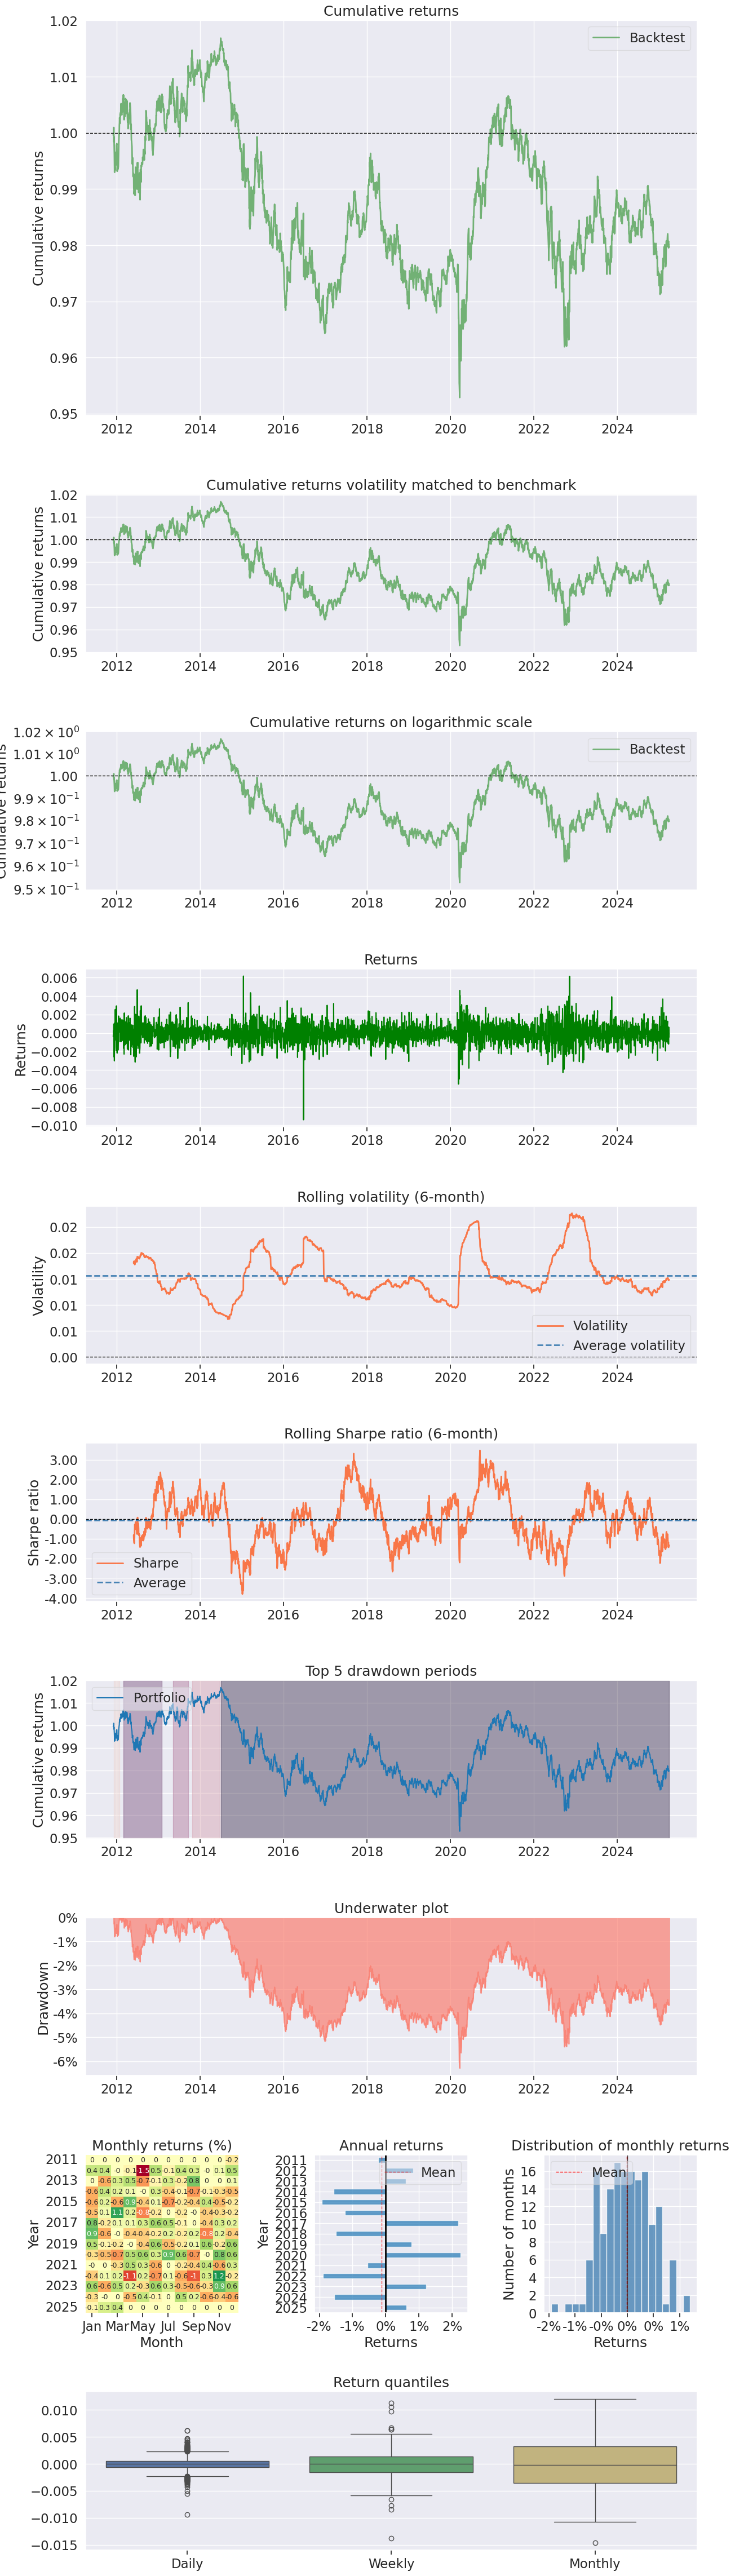

In [37]:
pf.create_returns_tear_sheet(start_of_day_data["log_returns_buy_hold_baseline"])

/Users/gzlotin/rl_diploma/experiments/baselines/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.008%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2011-12-02
End date,2025-03-31
Total months,163
,Backtest
Annual return,0.008%
Cumulative returns,0.11%
Annual volatility,1.394%
Sharpe ratio,0.01
Calmar ratio,0.00
Stability,0.01
Max drawdown,-5.645%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.65,2014-07-01,2020-03-23,NaT,NaN
1,1.69,2012-03-19,2012-06-01,2013-01-10,214
2,0.93,2013-05-08,2013-07-05,2013-09-18,96
3,0.83,2013-10-22,2014-02-03,2014-04-09,122
4,0.68,2011-12-07,2012-01-06,2012-01-27,38


/Users/gzlotin/rl_diploma/experiments/baselines/.venv/lib/python3.10/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


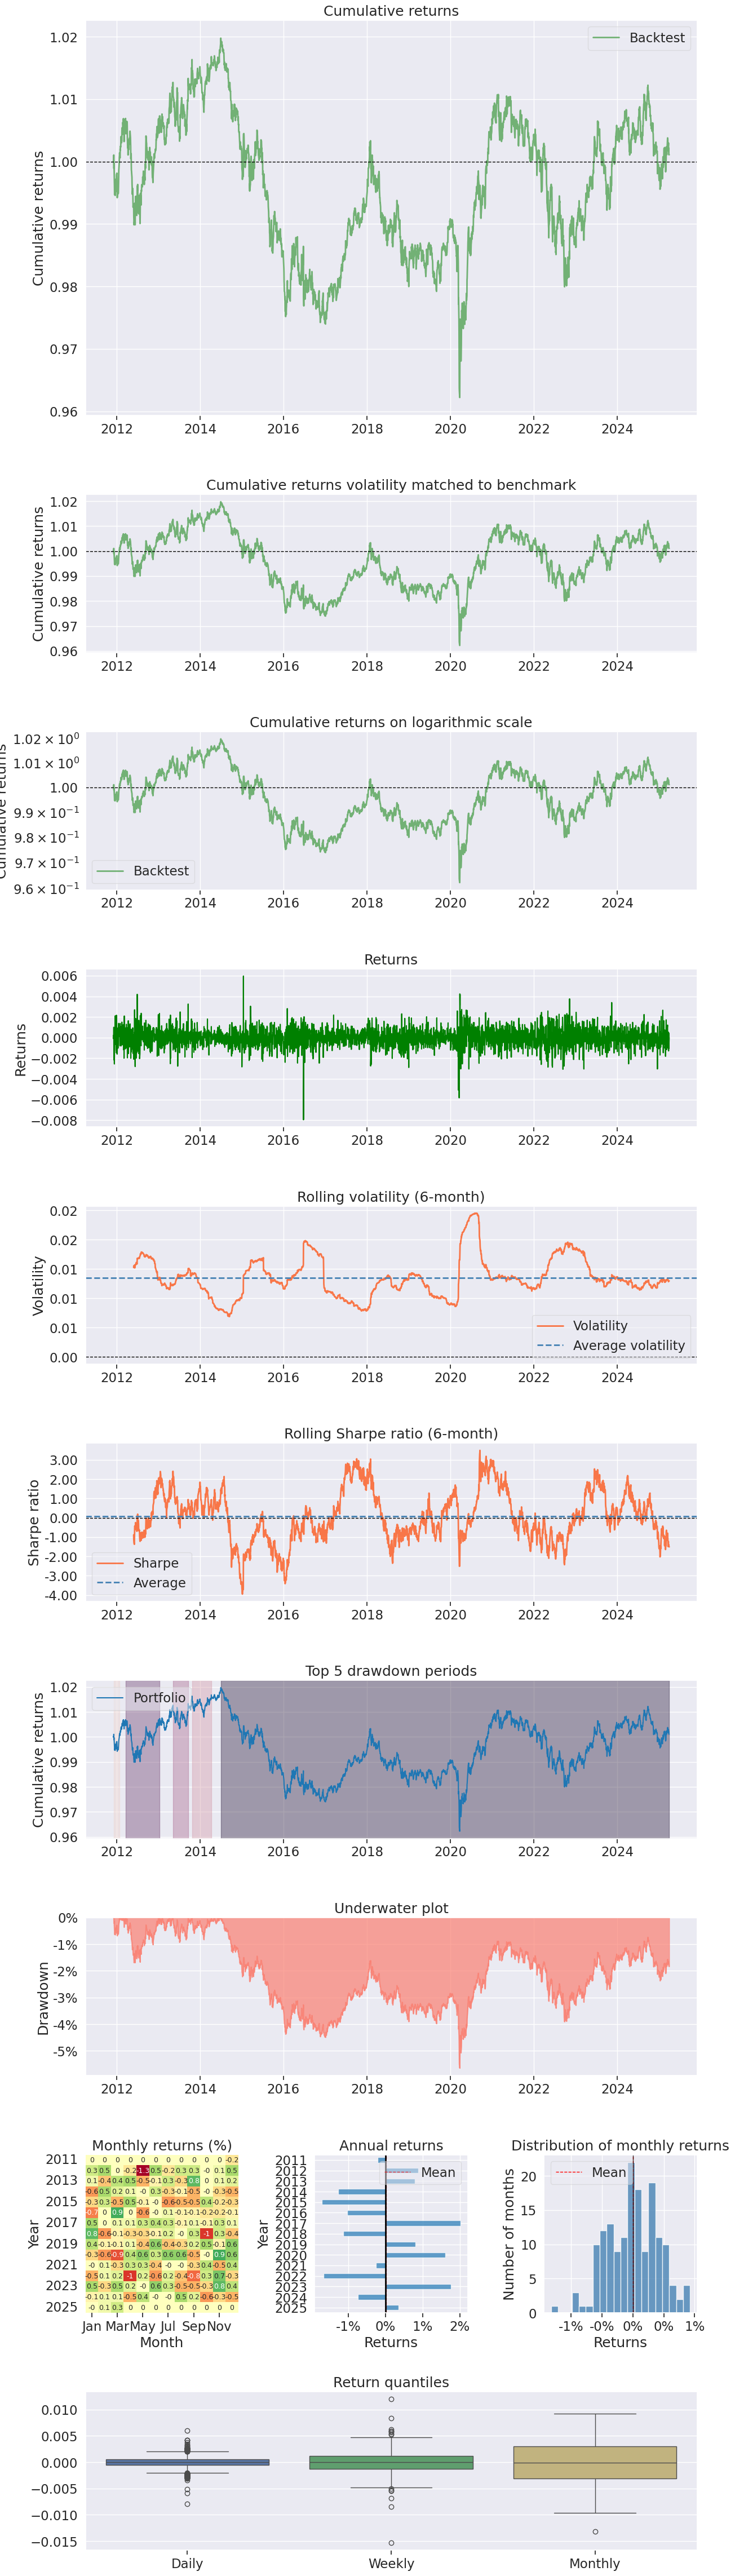

In [38]:
pf.create_returns_tear_sheet(start_of_day_data["log_returns_volatility_targeting"])

Итого оба метода дает отрицательную доходность, но у volatility_targeting ожидаемо меньшая волатильность